In [ ]:
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import shuffle

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau

from PIL import Image

import matplotlib.pyplot as plt
import zipfile
from keras.utils import load_img

import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d msambare/fer2013 

zip_ref = zipfile.ZipFile('fer2013.zip', 'r') # Opens the zip file in read mode
zip_ref.extractall('/fer2013') # Extracts the files into the /fer2013 folder
zip_ref.close()

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
 96% 58.0M/60.3M [00:02<00:00, 30.0MB/s]
100% 60.3M/60.3M [00:02<00:00, 22.1MB/s]


In [ ]:
train_path = "/fer2013/train/"
test_path = "/fer2013/test/"

print(os.listdir(test_path))
print(os.listdir(train_path))

['disgust', 'happy', 'sad', 'fear', 'surprise', 'neutral', 'angry']
['disgust', 'happy', 'sad', 'fear', 'surprise', 'neutral', 'angry']


In [ ]:
row, col = 48, 48
classes = 7

def count(path, set_):
    dict_ = {}
    for emotion in os.listdir(path):
        dir_ = path + emotion
        dict_[emotion] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = count(train_path, 'train')
test_count = count(test_path, 'test')

print(train_count)
print(test_count)

       disgust  happy   sad  fear  surprise  neutral  angry
train      436   7215  4830  4097      3171     4965   3995
      disgust  happy   sad  fear  surprise  neutral  angry
test      111   1774  1247  1024       831     1233    958


<Axes: >

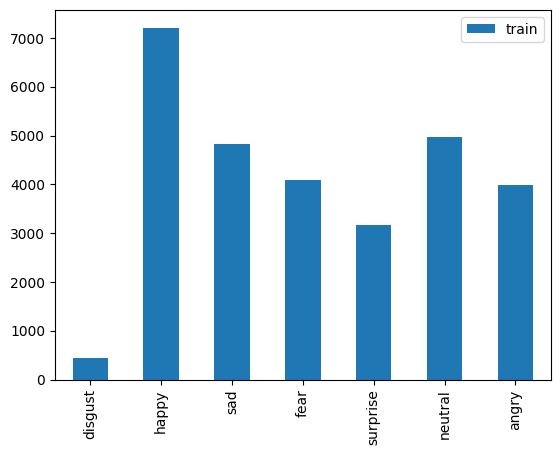

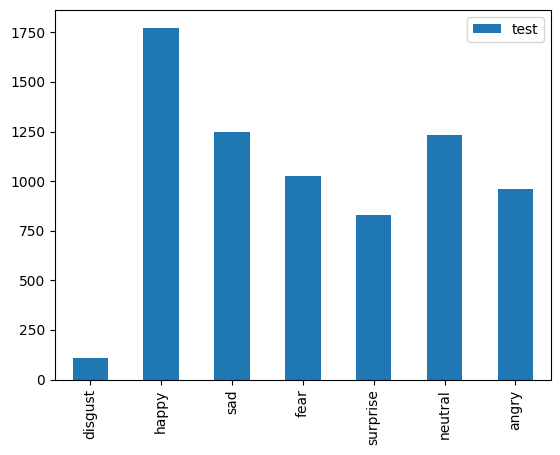

In [ ]:
train_count.transpose().plot(kind='bar')
test_count.transpose().plot(kind='bar')

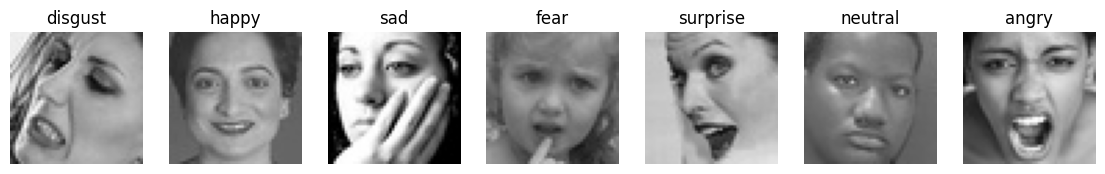

In [ ]:
plt.figure(figsize=(14,22))
i = 1
for emotion in os.listdir(train_path):
    img = load_img((train_path + emotion +'/'+ os.listdir(train_path + emotion)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(emotion)
    plt.axis('off')
    i += 1
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_path,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_path,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

training_set.class_indices


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
def get_model(input_size, classes=7, act = 'relu'):
    #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32,(3,3), activation = act, padding='valid', input_shape = input_size)) # Convolutional layers
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid')) # to reduce size of image
    model.add(Dropout(0.25)) # Dropout layer is a mask that nullifies the contribution of some neurons towards the next layer and leaves unmodified all others (Regularization)

    model.add(Conv2D(64,(3,3), activation = act, padding='valid'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
    model.add(Dropout(0.25))

    model.add(Conv2D(128,(3,3), activation = act, padding='valid'))
    model.add(Dropout(0.25))
    model.add(Flatten()) # L2 

    # Dense layer with 7 neurons (one for each class)
    model.add(Dense(classes, activation='softmax'))

    #Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def get_model(input_size, classes=7, act = 'relu'):
    #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32,(3,3), activation = act, padding='valid', input_shape = input_size)) # Convolutional layers
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid')) # to reduce size of image

    model.add(Conv2D(64,(3,3), activation = act, padding='valid'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))

    model.add(Conv2D(128,(3,3), activation = act, padding='valid'))
    model.add(Flatten()) # L2 

    # Dense layer with 7 neurons (one for each class)
    model.add(Dense(classes, activation='softmax'))

    #Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def get_model_dropout(input_size, classes=7, act = 'relu'):
    #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32,(3,3), activation = act, padding='valid', input_shape = input_size)) # Convolutional layers
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid')) # to reduce size of image
    model.add(Dropout(0.4)) # Dropout layer is a mask that nullifies the contribution of some neurons towards the next layer and leaves unmodified all others (Regularization)

    model.add(Conv2D(64,(3,3), activation = act, padding='valid'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
    model.add(Dropout(0.4))

    model.add(Conv2D(128,(3,3), activation = act, padding='valid'))
    model.add(Dropout(0.4))
    model.add(Flatten()) # L2 

    # Dense layer with 7 neurons (one for each class)
    model.add(Dense(classes, activation='softmax'))

    #Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def get_model_batch(input_size, classes=7, act = 'relu'):
    #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32,(3,3), activation = act, padding='valid', input_shape = input_size)) # Convolutional layers
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid')) # to reduce size of image
    model.add(Dropout(0.25)) # Dropout layer is a mask that nullifies the contribution of some neurons towards the next layer and leaves unmodified all others (Regularization)

    model.add(Conv2D(64,(3,3), activation = act, padding='valid'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(128,(3,3), activation = act, padding='valid'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten()) # L2 

    # Dense layer with 7 neurons (one for each class)
    model.add(Dense(classes, activation='softmax'))

    #Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    
# CNN architecture consists of three convolutional layers with 32, 64, and 128 filters
# Each convolutional layer is followed by a max pooling layer that reduces the spatial size of the feature maps
# Dropout regularization is applied after the max pooling layers to prevent overfitting. 
# Last layer is a dense layer with the number of neurons equal to the number of classes (activated using softmax activation function)
# Model compiled with the Adam optimizer with a learning rate of 0.0001, categorical cross-entropy loss function, and accuracy metric

In [ ]:
CNN_ReLU = get_model((row,col,1), classes, 'relu')
CNN_ReLU.summary()

CNN_ReLU_dp = get_model_dropout((row,col,1), classes, 'relu')
CNN_ReLU_dp.summary()

CNN_ReLU_batch = get_model_batch((row,col,1), classes, 'relu')
CNN_ReLU_batch.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 8192)              0

In [ ]:
CNN_tanh = get_model((row,col,1), classes, 'tanh')
CNN_tanh.summary()

CNN_tanh_dp = get_model_dropout((row,col,1), classes, 'tanh')
CNN_tanh_dp.summary()

CNN_tanh_batch = get_model_batch((row,col,1), classes, 'tanh')
CNN_tanh_batch.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 8192)             

In [ ]:
CNN_log = get_model((row,col,1), classes, 'sigmoid')
CNN_log.summary()

CNN_log_dp = get_model_dropout((row,col,1), classes, 'sigmoid')
CNN_log_dp.summary()

CNN_log_batch = get_model_batch((row,col,1), classes, 'sigmoid')
CNN_log_batch.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 flatten_6 (Flatten)         (None, 8192)             

In [ ]:
# Define the callback
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)


In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist_ReLU = CNN_ReLU.fit(x=training_set,
                 validation_data=test_set,
                 epochs=20,
                 callbacks=[checkpoint_callback],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

hist_ReLU_dp = CNN_ReLU_dp.fit(x=training_set,
                 validation_data=test_set,
                 epochs=20,
                 callbacks=[checkpoint_callback],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

hist_ReLU_batch = CNN_ReLU_batch.fit(x=training_set,
                 validation_data=test_set,
                 epochs=20,
                 callbacks=[checkpoint_callback],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/20
448/448 [==============================] - ETA: 0s - loss: 1.7936 - accuracy: 0.2623
Epoch 1: val_accuracy improved from -inf to 0.30901, saving model to model_weights.h5
448/448 [==============================] - 139s 306ms/step - loss: 1.7936 - accuracy: 0.2623 - val_loss: 1.7278 - val_accuracy: 0.3090
Epoch 2/20
448/448 [==============================] - ETA: 0s - loss: 1.6909 - accuracy: 0.3286
Epoch 2: val_accuracy improved from 0.30901 to 0.37500, saving model to model_weights.h5
448/448 [==============================] - 136s 304ms/step - loss: 1.6909 - accuracy: 0.3286 - val_loss: 1.6243 - val_accuracy: 0.3750
Epoch 3/20
448/448 [==============================] - ETA: 0s - loss: 1.6506 - accuracy: 0.3532
Epoch 3: val_accuracy improved from 0.37500 to 0.38672, saving model to model_weights.h5
448/448 [==============================] - 135s 302ms/step - loss: 1.6506 - accuracy: 0.3532 - val_loss: 1.5884 - val_accuracy: 0.3867
Epoch 4/20
448/448 [=======================

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist_tanh = CNN_tanh.fit(x=training_set,
                 validation_data=test_set,
                 epochs=20,
                 callbacks=[checkpoint_callback],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

hist_tanh_dp = CNN_tanh_dp.fit(x=training_set,
                 validation_data=test_set,
                 epochs=20,
                 callbacks=[checkpoint_callback],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

hist_tanh_batch = CNN_tanh_batch.fit(x=training_set,
                 validation_data=test_set,
                 epochs=20,
                 callbacks=[checkpoint_callback],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/20
448/448 [==============================] - ETA: 0s - loss: 1.7597 - accuracy: 0.2878
Epoch 1: val_accuracy did not improve from 0.52358
448/448 [==============================] - 127s 281ms/step - loss: 1.7597 - accuracy: 0.2878 - val_loss: 1.6590 - val_accuracy: 0.3670
Epoch 2/20
448/448 [==============================] - ETA: 0s - loss: 1.6720 - accuracy: 0.3449
Epoch 2: val_accuracy did not improve from 0.52358
448/448 [==============================] - 131s 292ms/step - loss: 1.6720 - accuracy: 0.3449 - val_loss: 1.6098 - val_accuracy: 0.3862
Epoch 3/20
448/448 [==============================] - ETA: 0s - loss: 1.6428 - accuracy: 0.3612
Epoch 3: val_accuracy did not improve from 0.52358
448/448 [==============================] - 131s 292ms/step - loss: 1.6428 - accuracy: 0.3612 - val_loss: 1.5881 - val_accuracy: 0.3836
Epoch 4/20
448/448 [==============================] - ETA: 0s - loss: 1.6221 - accuracy: 0.3705
Epoch 4: val_accuracy did not improve from 0.52358
448/448

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist_log = CNN_log.fit(x=training_set,
                 validation_data=test_set,
                 epochs=20,
                 callbacks=[checkpoint_callback],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

hist_log_dp = CNN_log_dp.fit(x=training_set,
                 validation_data=test_set,
                 epochs=20,
                 callbacks=[checkpoint_callback],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

hist_log_batch = CNN_log_batch.fit(x=training_set,
                 validation_data=test_set,
                 epochs=20,
                 callbacks=[checkpoint_callback],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/20
448/448 [==============================] - ETA: 0s - loss: 1.8323 - accuracy: 0.2335
Epoch 1: val_accuracy improved from -inf to 0.24721, saving model to model_weights.h5
448/448 [==============================] - 151s 329ms/step - loss: 1.8323 - accuracy: 0.2335 - val_loss: 1.8260 - val_accuracy: 0.2472
Epoch 2/20
448/448 [==============================] - 144s 322ms/step - loss: 1.8227 - accuracy: 0.2399 - val_loss: 1.8235 - val_accuracy: 0.2469
Epoch 3/20
448/448 [==============================] - ETA: 0s - loss: 1.8162 - accuracy: 0.2467
Epoch 3: val_accuracy improved from 0.24721 to 0.24735, saving model to model_weights.h5
448/448 [==============================] - 144s 320ms/step - loss: 1.8162 - accuracy: 0.2467 - val_loss: 1.8169 - val_accuracy: 0.2473
Epoch 4/20
448/448 [==============================] - ETA: 0s - loss: 1.8131 - accuracy: 0.2513
Epoch 4: val_accuracy did not improve from 0.24735
448/448 [==============================] - 143s 318ms/step - loss: 1.8

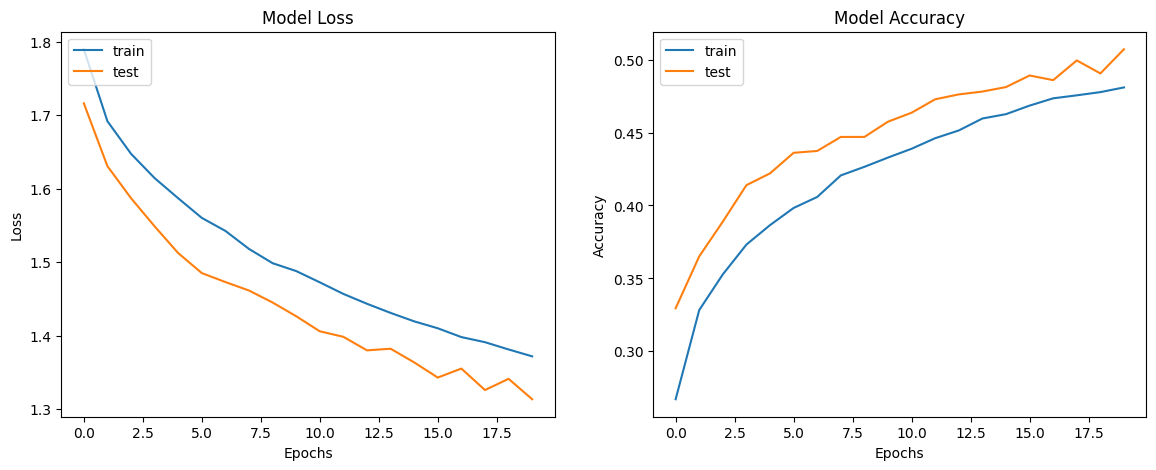

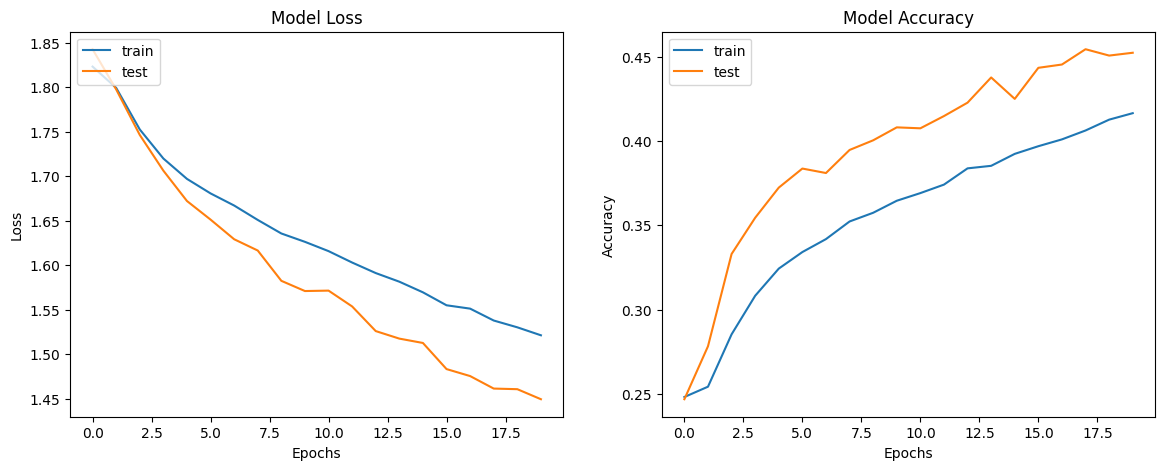

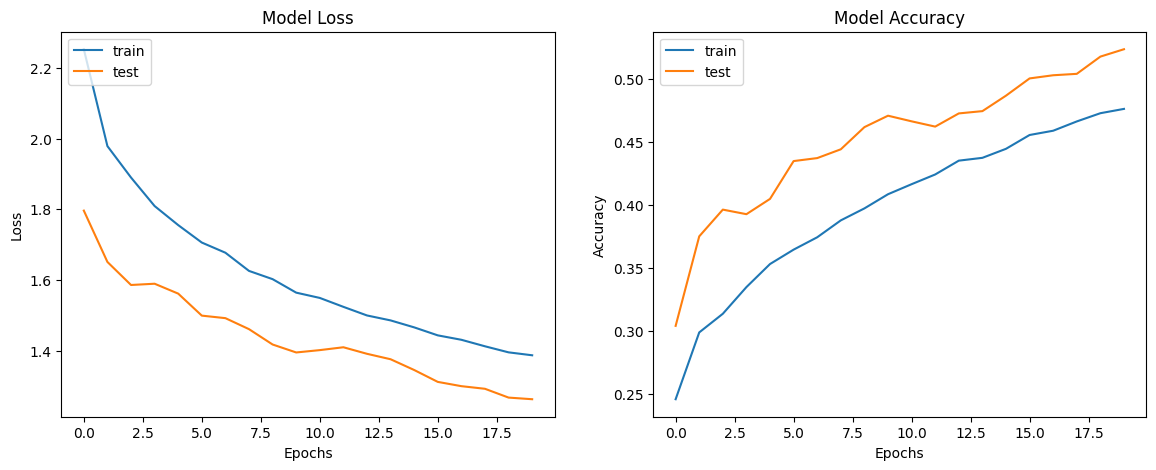

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist_ReLU.history['accuracy'])
plt.plot(hist_ReLU.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist_ReLU.history['loss'])
plt.plot(hist_ReLU.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist_ReLU_dp.history['accuracy'])
plt.plot(hist_ReLU_dp.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist_ReLU_dp.history['loss'])
plt.plot(hist_ReLU_dp.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist_ReLU_batch.history['accuracy'])
plt.plot(hist_ReLU_batch.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist_ReLU_batch.history['loss'])
plt.plot(hist_ReLU_batch.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_loss, train_accuracy = CNN_ReLU.evaluate(training_set)
test_loss, test_accuracy = CNN_ReLU.evaluate(test_set)
print("Train accuracy = {:.2f} , Test accuracy = {:.2f}".format(train_accuracy*100, test_accuracy*100))

train_loss, train_accuracy = CNN_ReLU_dp.evaluate(training_set)
test_loss, test_accuracy = CNN_ReLU_dp.evaluate(test_set)
print("Train accuracy = {:.2f} , Test accuracy = {:.2f}".format(train_accuracy*100, test_accuracy*100))

train_loss, train_accuracy = CNN_ReLU_batch.evaluate(training_set)
test_loss, test_accuracy = CNN_ReLU_batch.evaluate(test_set)
print("Train accuracy = {:.2f} , Test accuracy = {:.2f}".format(train_accuracy*100, test_accuracy*100))

113/113 [==============================] - 9s 81ms/step - loss: 1.3134 - accuracy: 0.5068
Train accuracy = 48.08 , Test accuracy = 50.68
113/113 [==============================] - 9s 80ms/step - loss: 1.4496 - accuracy: 0.4521
Train accuracy = 43.91 , Test accuracy = 45.21
113/113 [==============================] - 10s 88ms/step - loss: 1.2638 - accuracy: 0.5235
Train accuracy = 51.23 , Test accuracy = 52.35


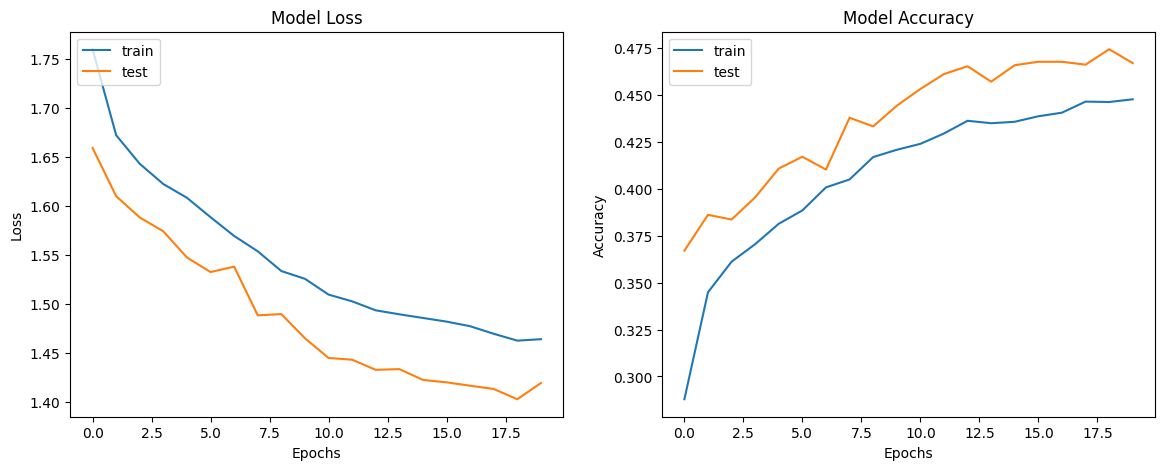

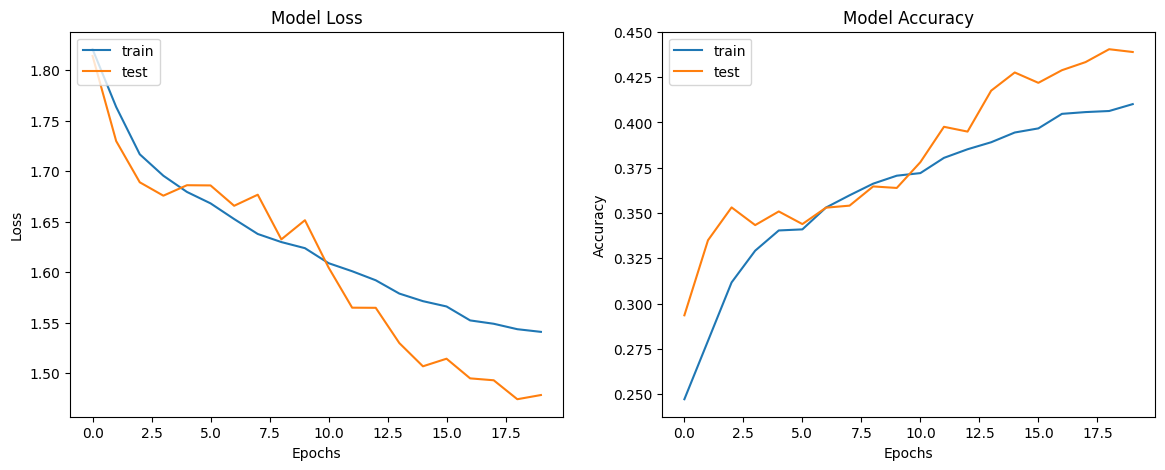

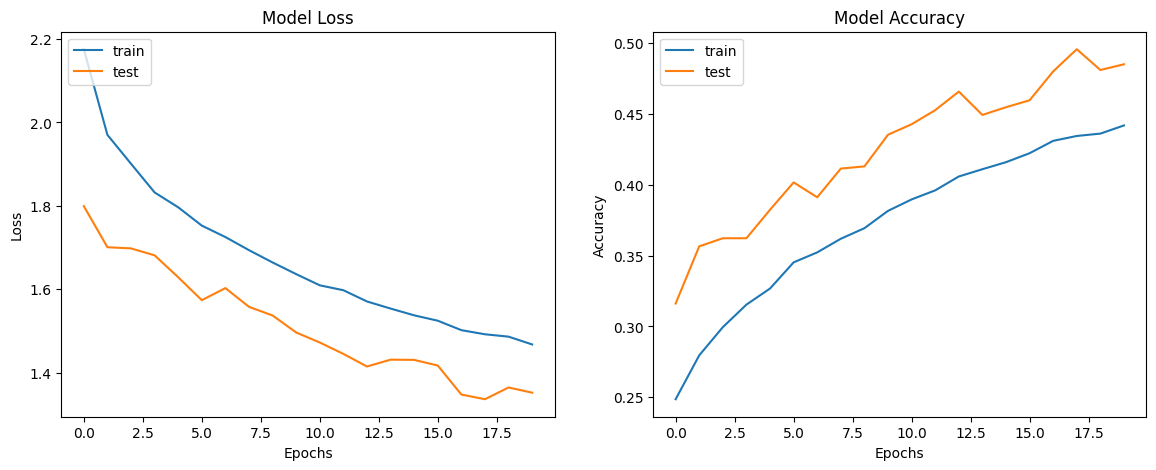

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist_tanh.history['accuracy'])
plt.plot(hist_tanh.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist_tanh.history['loss'])
plt.plot(hist_tanh.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')

plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist_tanh_dp.history['accuracy'])
plt.plot(hist_tanh_dp.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist_tanh_dp.history['loss'])
plt.plot(hist_tanh_dp.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')

plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist_tanh_batch.history['accuracy'])
plt.plot(hist_tanh_batch.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist_tanh_batch.history['loss'])
plt.plot(hist_tanh_batch.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_loss, train_accuracy = CNN_tanh.evaluate(training_set)
test_loss, test_accuracy = CNN_tanh.evaluate(test_set)
print("Train accuracy = {:.2f} , Test accuracy = {:.2f}".format(train_accuracy*100, test_accuracy*100))

train_loss, train_accuracy = CNN_tanh_dp.evaluate(training_set)
test_loss, test_accuracy = CNN_tanh_dp.evaluate(test_set)
print("Train accuracy = {:.2f} , Test accuracy = {:.2f}".format(train_accuracy*100, test_accuracy*100))

train_loss, train_accuracy = CNN_tanh_batch.evaluate(training_set)
test_loss, test_accuracy = CNN_tanh_batch.evaluate(test_set)
print("Train accuracy = {:.2f} , Test accuracy = {:.2f}".format(train_accuracy*100, test_accuracy*100))

113/113 [==============================] - 8s 70ms/step - loss: 1.4187 - accuracy: 0.4675
Train accuracy = 45.18 , Test accuracy = 46.75
113/113 [==============================] - 9s 82ms/step - loss: 1.4780 - accuracy: 0.4391
Train accuracy = 41.71 , Test accuracy = 43.91
113/113 [==============================] - 10s 84ms/step - loss: 1.3514 - accuracy: 0.4847
Train accuracy = 46.10 , Test accuracy = 48.47


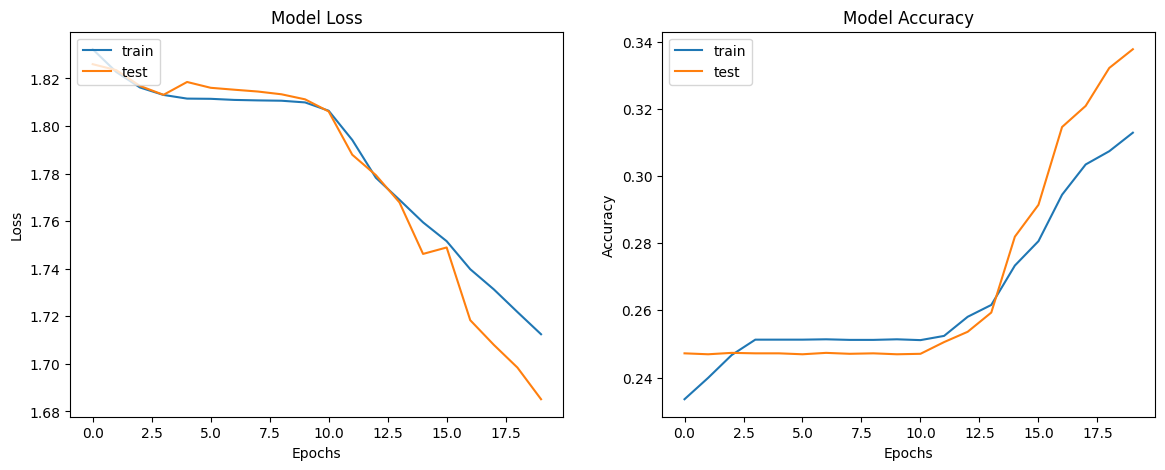

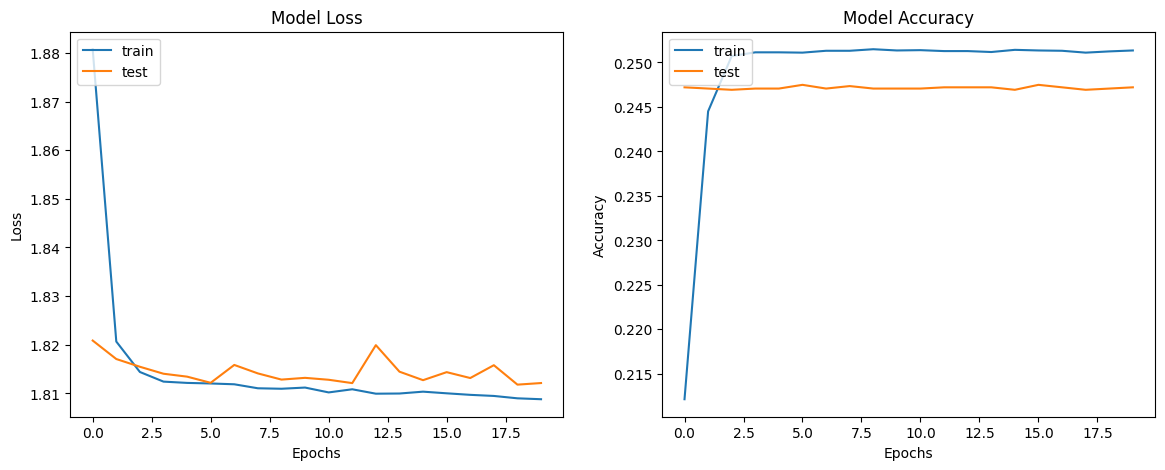

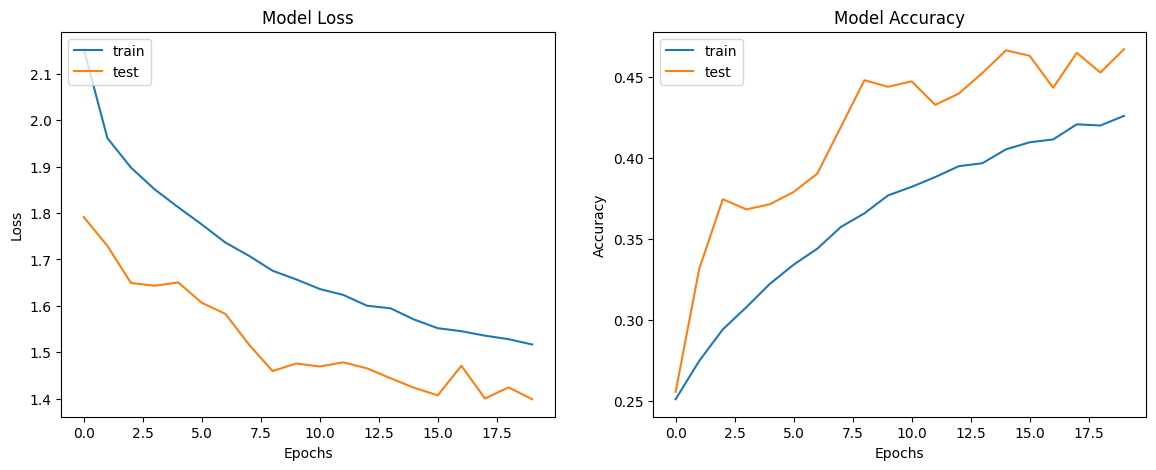

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist_log.history['accuracy'])
plt.plot(hist_log.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist_log.history['loss'])
plt.plot(hist_log.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')


plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist_log_dp.history['accuracy'])
plt.plot(hist_log_dp.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist_log_dp.history['loss'])
plt.plot(hist_log_dp.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')

plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist_log_batch.history['accuracy'])
plt.plot(hist_log_batch.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist_log_batch.history['loss'])
plt.plot(hist_log_batch.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_loss, train_accuracy = CNN_log.evaluate(training_set)
test_loss, test_accuracy = CNN_log.evaluate(test_set)
print("Train accuracy = {:.2f} , Test accuracy = {:.2f}".format(train_accuracy*100, test_accuracy*100))

train_loss, train_accuracy = CNN_log_dp.evaluate(training_set)
test_loss, test_accuracy = CNN_log_dp.evaluate(test_set)
print("Train accuracy = {:.2f} , Test accuracy = {:.2f}".format(train_accuracy*100, test_accuracy*100))

train_loss, train_accuracy = CNN_log_batch.evaluate(training_set)
test_loss, test_accuracy = CNN_log_batch.evaluate(test_set)
print("Train accuracy = {:.2f} , Test accuracy = {:.2f}".format(train_accuracy*100, test_accuracy*100))

113/113 [==============================] - 10s 92ms/step - loss: 1.6847 - accuracy: 0.3383
Train accuracy = 31.60 , Test accuracy = 33.83
113/113 [==============================] - 10s 92ms/step - loss: 1.8121 - accuracy: 0.2471
Train accuracy = 25.13 , Test accuracy = 24.71
113/113 [==============================] - 12s 106ms/step - loss: 1.3984 - accuracy: 0.4673
Train accuracy = 45.88 , Test accuracy = 46.73


449/449 [==============================] - 46s 102ms/step
Training Set Confusion Matrix
[[ 644    2  209 1251  715  623  551]
 [  60    0   19  146   80   65   66]
 [ 685    2  239 1240  735  631  565]
 [1232    2  396 2280 1235 1065 1005]
 [ 805    1  285 1531  906  761  676]
 [ 823    2  285 1484  891  714  631]
 [ 520    1  159 1022  552  472  445]]
Training Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.16      0.15      3995
     disgust       0.00      0.00      0.00       436
        fear       0.15      0.06      0.08      4097
       happy       0.25      0.32      0.28      7215
     neutral       0.18      0.18      0.18      4965
         sad       0.16      0.15      0.16      4830
    surprise       0.11      0.14      0.13      3171

    accuracy                           0.18     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.18      0.18      0.17     28709



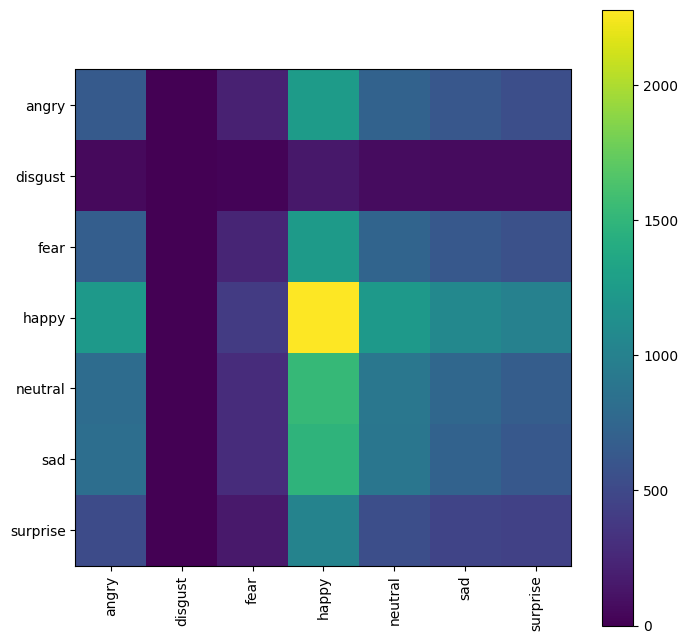

In [ ]:
y_pred = CNN_ReLU.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(training_set.classes, y_pred)
print('Training Set Confusion Matrix')
print(cm_train)
print('Training Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)